In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Install Normalizer**

In [2]:
!pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-oovkzc17
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-oovkzc17
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6860 sha256=b7c883e65f133579a0b6859a63073ec6bd00c44e2411b1bbf6827de5fe67f1d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-_z32tmuq/wheels/9a/af/fc/4c056274507dc80328a36c6ee1b71d78d6473edb0c1f5edc3e
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186456 sha256=6332e85a3f36e71ee9393074d27fcc7a7e996ae1

# **import necessary libraries**

In [8]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from normalizer import normalize

# **Dataset Loading**

In [9]:
# Load dataset
DATA_DIR = "/content/drive/MyDrive/dataset"
train_df = pd.read_csv(f"{DATA_DIR}/dataset.csv")

# **Display Few Sample**

In [10]:
train_df.head()

,comment,Category,Gender,comment react number,label
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,Actor,Female,1.0,sexual
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...,Singer,Male,2.0,not bully
2,"অরে বাবা, এই টা কোন পাগল????",Actor,Female,2.0,not bully
3,ক্যাপ্টেন অফ বাংলাদেশ,Sports,Male,0.0,not bully
4,পটকা মাছ,Politician,Male,0.0,troll


# **Rename Columns(optional)**

In [11]:
# Rename columns
train_df.rename(columns={
    'comment': 'text',
    'Category': 'category',
    'Gender': 'gender',
    'comment react number': 'react_count',
    'label': 'label'
}, inplace=True)


# **Drop Null and Duplicate Values**

In [12]:
# Drop NA and duplicates
train_df.dropna(subset=['text', 'label'], inplace=True)
train_df.drop_duplicates(subset='text', inplace=True)

# **label mapping**

In [13]:
# Encode labels
label_map = {
    "sexual":  0,
    "not bully": 1,
    "troll": 2,
    "religious": 3,
    "threat": 4
}

In [14]:
train_df['label'] = train_df['label'].map(label_map)

# **Cleaning text**

In [15]:
# Preprocessing function
def clean_text(text):
    text = str(text).strip()
    text = normalize(text)
    text = text.lower()
    text = re.sub(r'http\S+|@[\w]+|#[\w]+|[0-9০১২৩৪৫৬৭৮৯]+', ' ', text)
    text = re.sub(r'[^\u0980-\u09FF\s]', ' ', text)  # Keep Bangla chars
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

train_df['clean_text'] = train_df['text'].apply(clean_text)

# **Label Distribution**

<ipython-input-25-51e4973d1256>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=train_df, palette='viridis')


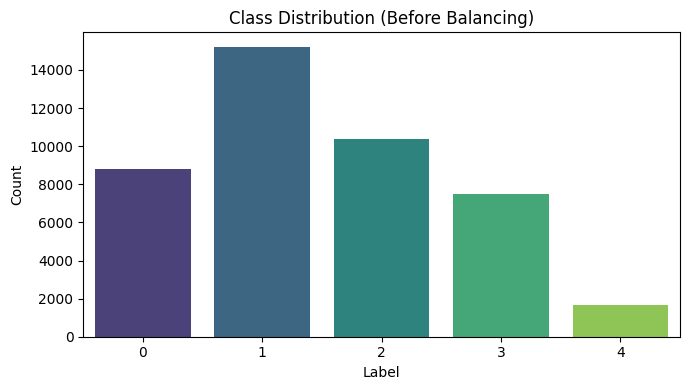

In [25]:
# Label distribution before balancing
plt.figure(figsize=(7, 4))
sns.countplot(x='label', data=train_df, palette='viridis')
plt.title("Class Distribution (Before Balancing)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# **Comment length**

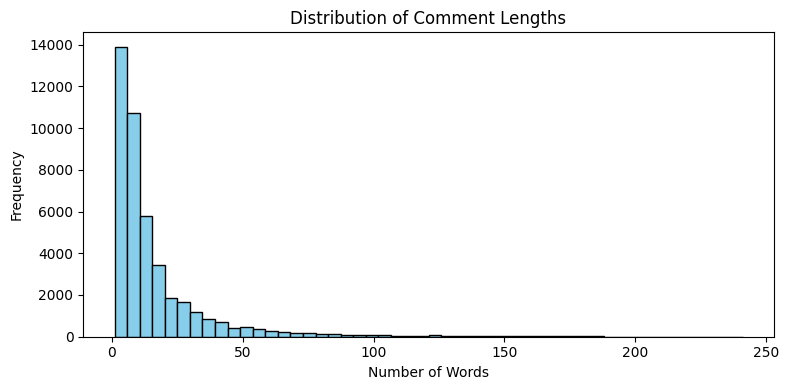

In [26]:
# Comment length distribution
train_df['text_len'] = train_df['clean_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 4))
plt.hist(train_df['text_len'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Comment Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [16]:
# Drop empty cleaned rows
train_df = train_df[train_df['clean_text'].astype(bool)]

# **Oversampling for balance dataset**

In [17]:
# Balance the data using oversampling
max_count = train_df['label'].value_counts().max()
balanced_df = pd.concat([
    resample(group, replace=True, n_samples=max_count, random_state=42)
    for _, group in train_df.groupby('label')
]).sample(frac=1, random_state=42).reset_index(drop=True)

# **Split Data**

In [19]:
#Train-Test Split
X = balanced_df['clean_text']
y = balanced_df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# **Tf-IDF for convert into vector**

In [20]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# **Model Deployment**

In [21]:
# Logistic Regression Model
clf = LogisticRegression(max_iter=300, class_weight='balanced')
clf.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=300)

In [22]:
# Predictions
y_pred = clf.predict(X_test_tfidf)

# **Model Evaluation**

In [23]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_map.keys()))

Classification Report:

              precision    recall  f1-score   support

      sexual       0.60      0.54      0.57      3043
   not bully       0.55      0.69      0.61      3042
       troll       0.63      0.51      0.56      3043
   religious       0.65      0.63      0.64      3043
      threat       0.71      0.75      0.73      3043

    accuracy                           0.62     15214
   macro avg       0.63      0.62      0.62     15214
weighted avg       0.63      0.62      0.62     15214



# **Confusion matrix**

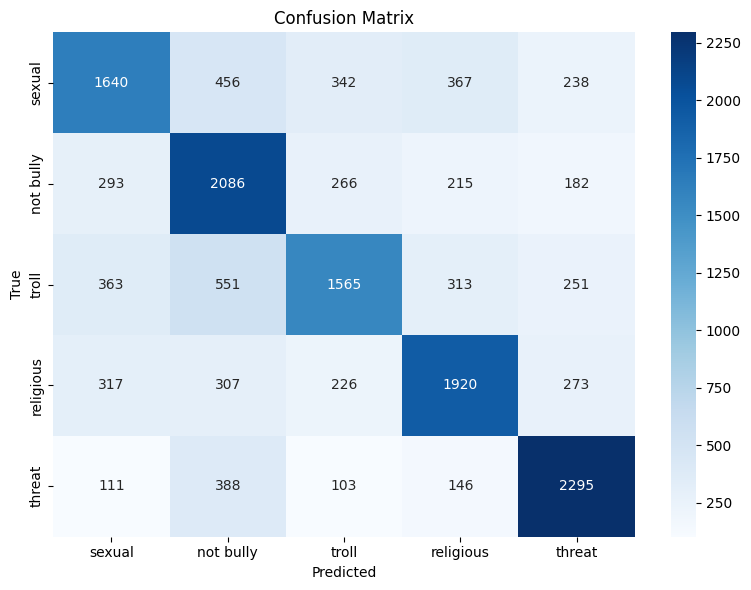

In [24]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()